In [ ]:
!pip install -q tensorflow-text 
!pip install -q tf-models-official 
!pip install bert-for-tf2
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 15.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 66.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
   

In [ ]:
!pip install -U numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 63.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.


In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
tf.get_logger().setLevel('ERROR')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout

RuntimeError: ignored

ImportError: ignored

In [ ]:
raw_data = pd.read_csv("/content/reto_precios.csv")
raw_data = raw_data[['main_name','location',
                     'description', 'attributes',
                     'vendor','final_price']]
raw_data.dropna(inplace=True)
raw_data['Text'] = (raw_data['main_name'] + ' '+ raw_data['vendor'] 
                    + ' ' + raw_data['location'] 
                    + ' ' + raw_data['attributes']
                    + ' '+ raw_data['description'])
raw_data = raw_data.drop(['main_name','location','description', 'vendor', 'attributes'], axis = 1)
raw_data.head()

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm, skew, kurtosis
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

plt.hist(raw_data['final_price'], bins=30, alpha=0.5)
plt.xlabel('Final price')
plt.ylabel('Frequency')
plt.title('Precio')
plt.grid(True)
plt.show()

skewness = skew(raw_data['final_price'])
kurt = kurtosis(raw_data['final_price'])

print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
raw_data['final_price_scaled'] = scaler.fit_transform(raw_data[['final_price']])

In [ ]:
raw_data.shape

In [ ]:
!pip install nltk

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def preprocess_text(sen):
  """
  """

  tokens = sen.lower().split()
    
  stop_words = set(stopwords.words('spanish'))
  tokens = [word for word in tokens if word not in stop_words]
    
  sentence = ' '.join(tokens)
  
  sentence = TAG_RE.sub('', sen) # html
  sentence = re.sub('[^a-zA-Z0-9]', ' ', sentence) # puntuación
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) #letras sueltas
  sentence = re.sub(r'\s+', ' ', sentence) # espacios excesivos
    
  return sentence

In [ ]:
sentences = list(raw_data['Text'])
data = np.array([str.encode(preprocess_text(sen)) for sen in sentences], dtype=object)

In [ ]:
y = np.array(raw_data['final_price_scaled'])
print(y[0:10])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.2)

print(x_train.shape)
print(x_test.shape)
print(y_train.sum())
print(y_test.sum())

In [ ]:
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

preprocessor = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing') #BERT tokenizer
tokenized = preprocessor(text_input)

encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder') #BERT embedding and encoding
embedded = encoder(tokenized)

net = embedded['pooled_output']
net = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(net)
net = tf.keras.layers.Dropout(0.5)(net)
net = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(net)
net = tf.keras.layers.Dropout(0.5)(net)
net = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(net)
net = tf.keras.layers.Dropout(0.5)(net)
net = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(net)

model_BERT = tf.keras.Model(text_input, net)
model_BERT.summary()

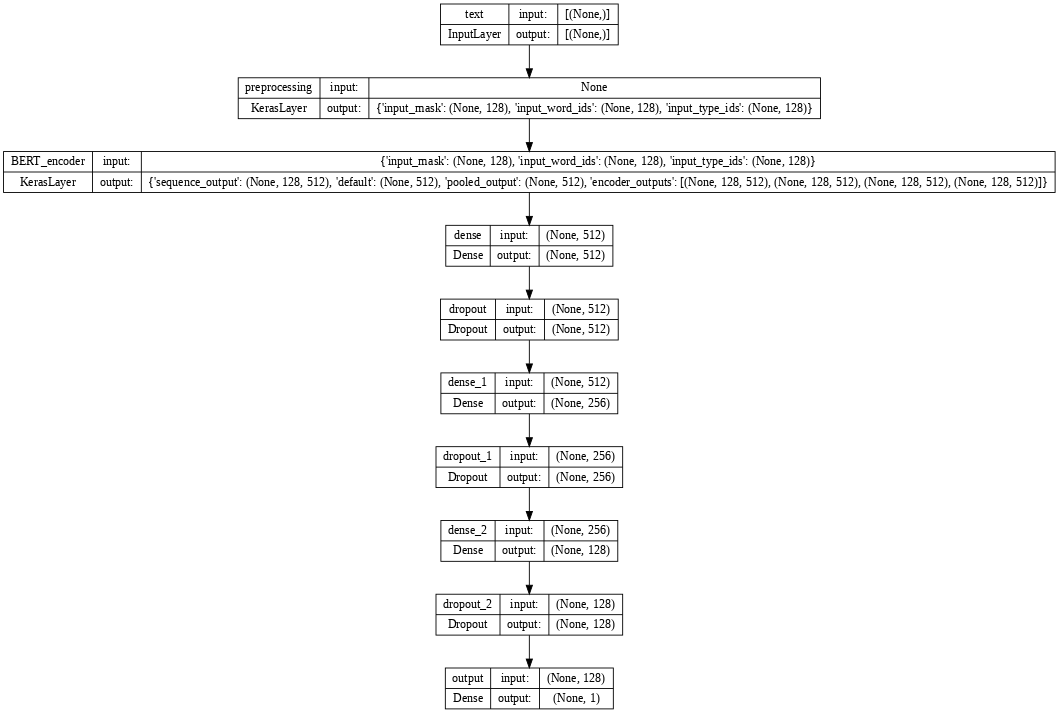

In [ ]:
# Plot it
tf.keras.utils.plot_model(model_BERT, show_shapes=True, show_layer_names=True, dpi=64)

In [ ]:
# Custom compilation
epochs = 300
steps_per_epoch = 500
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

model_BERT.compile(optimizer=optimizer,
                   loss=tf.keras.losses.MeanSquaredError(),
                   metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, model, filepath, save_frequency):
        super(CustomModelCheckpoint, self).__init__()
        self.save_freq = save_frequency
        self.model = model
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save_weights(self.filepath.format(epoch=epoch))

save_frequency = 5
filepath = "model_BERT_weights.h5"
callbacks = [CustomModelCheckpoint(model_BERT, filepath, save_frequency)]

In [ ]:
model_BERT.load_weights(filepath)

In [ ]:
# Training
history = model_BERT.fit(x=x_train, y=y_train, epochs=epochs, validation_split=0.1, callbacks=callbacks)

Epoch 1/300
23/23 [==============================] - 11s 255ms/step - loss: 0.7575 - mean_absolute_error: 0.0667 - val_loss: 0.7549 - val_mean_absolute_error: 0.0527
Epoch 2/300
23/23 [==============================] - 6s 266ms/step - loss: 0.7576 - mean_absolute_error: 0.0659 - val_loss: 0.7548 - val_mean_absolute_error: 0.0521
Epoch 3/300
23/23 [==============================] - 6s 248ms/step - loss: 0.7576 - mean_absolute_error: 0.0672 - val_loss: 0.7548 - val_mean_absolute_error: 0.0523
Epoch 4/300
23/23 [==============================] - 5s 237ms/step - loss: 0.7581 - mean_absolute_error: 0.0685 - val_loss: 0.7548 - val_mean_absolute_error: 0.0529
Epoch 5/300
23/23 [==============================] - 7s 288ms/step - loss: 0.7578 - mean_absolute_error: 0.0691 - val_loss: 0.7545 - val_mean_absolute_error: 0.0517
Epoch 6/300
23/23 [==============================] - 5s 236ms/step - loss: 0.7570 - mean_absolute_error: 0.0652 - val_loss: 0.7543 - val_mean_absolute_error: 0.0506
Epoch 7/3

In [ ]:
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

In [ ]:
loss, accuracy = model_BERT.evaluate(x_test, y_test)

print(f'Loss: {loss}')
print(f'Mean Absolute Error: {accuracy}')

7/7 [==============================] - 1s 182ms/step - loss: 0.1943 - mean_absolute_error: 0.0449
Loss: 0.19432677328586578
Mean Absolute Error: 0.044858694076538086


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

y_pred = model_BERT.predict(x_test)

mape = mean_absolute_percentage_error(y_test, y_pred)

accuracy = 1 - mape

print(f"Accuracy: {accuracy:.2f}%")

7/7 [==============================] - 1s 116ms/step
Accuracy: -731033803094.31%


In [ ]:
X = raw_data['final_price'].values.reshape(-1, 1)
scaler.fit(X)

MinMaxScaler()

In [ ]:
y_test = y_test.reshape(-1,1)

y_pred_unscaled = scaler.inverse_transform(y_pred)
y_test_unscaled = scaler.inverse_transform(y_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)

mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)

r2 = r2_score(y_test_unscaled, y_pred_unscaled)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R^2) Score: {r2:.4f}")

Mean Squared Error (MSE): 2090950441833.2131
Mean Absolute Error (MAE): 973244.4410
R-squared (R^2) Score: 0.7334
